In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [3]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


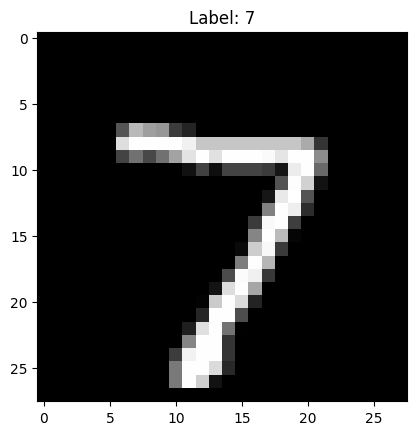

In [4]:
import matplotlib.pyplot as plt
def show_image(image, label):
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f'Label: {label}')
    plt.show()
show_image(X[0], y[0])

In [5]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [31]:
mask = act1 < 0.0
mask.float().sum(), act1.numel()

(tensor(0., device='mps:0'), 7680)

In [36]:
act1.shape
s = act1.sum(dim=0)
s.shape

torch.Size([120])

In [14]:
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/mnist_relu_1')
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        # input: 28 * 28
        # after first conv with kernel size 5: 24 * 24
        # after first pool: 12 * 12
        # after second conv with kernel size 5: 8 * 8
        # after second pool: 4 * 4
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        nn.init.xavier_uniform_(self.fc1.weight, gain=nn.init.calculate_gain('relu'))
        self.fc2 = nn.Linear(120, 84)
        nn.init.xavier_uniform_(self.fc2.weight, gain=nn.init.calculate_gain('relu')) 
        self.fc3 = nn.Linear(84, 10)
        nn.init.xavier_uniform_(self.fc3.weight, gain=nn.init.calculate_gain('relu')) 

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        act1 = F.relu(self.fc1(x))
        act2 = F.relu(self.fc2(act1))
        x = self.fc3(act2)
        return x, act1, act2


model = NeuralNetwork().to(device)
print(model)
X = X.to(device)
x = X[0].to(device)
model(X)

NeuralNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


(tensor([[ 2.1413e-01, -1.3174e-01, -1.7960e-01,  8.1790e-02,  2.8773e-01,
           7.6665e-02, -5.2325e-02, -5.4442e-02, -2.3105e-01, -2.5383e-01],
         [ 2.7132e-01, -1.9914e-01, -1.7635e-01,  1.7164e-01,  2.8408e-01,
           7.9833e-02,  6.5947e-02, -8.1150e-02, -1.6381e-01, -4.1387e-01],
         [ 2.0279e-01, -2.0074e-01, -1.4522e-01,  7.1057e-02,  1.5798e-01,
           1.3737e-01,  5.5082e-02, -3.3226e-02, -1.4558e-01, -2.1639e-01],
         [ 3.3408e-01, -2.4143e-01, -7.0178e-02,  3.2176e-01,  3.2919e-01,
           4.0479e-02,  4.3348e-02, -3.5875e-02, -9.5553e-02, -4.3689e-01],
         [ 2.4855e-01, -1.5805e-01, -1.3531e-01,  2.6214e-01,  3.6463e-01,
           1.0297e-01,  1.9478e-03, -1.2961e-01, -1.4957e-01, -3.1446e-01],
         [ 2.2038e-01, -2.1186e-01, -1.4744e-01,  7.2944e-02,  2.0147e-01,
           1.6092e-01,  4.4065e-02, -3.2001e-02, -1.2499e-01, -2.3656e-01],
         [ 2.8013e-01, -2.4514e-01, -1.1981e-01,  2.5401e-01,  4.1937e-01,
           7.6577e-

In [7]:
import numpy as np
total_params = 0
for params in model.parameters():
    current_layer_size = np.prod(params.shape)
    print("Current layer size: ", current_layer_size)
    total_params += current_layer_size
total_params

Current layer size:  150
Current layer size:  6
Current layer size:  2400
Current layer size:  16
Current layer size:  30720
Current layer size:  120
Current layer size:  10080
Current layer size:  84
Current layer size:  840
Current layer size:  10


44426

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [9]:
pred, act1, act2 = model(X)
act1.shape, act1

(torch.Size([64, 120]),
 tensor([[0.0185, 0.0000, 0.1110,  ..., 0.0000, 0.0468, 0.0737],
         [0.0135, 0.0000, 0.1729,  ..., 0.0000, 0.0393, 0.1351],
         [0.0040, 0.0255, 0.1510,  ..., 0.0765, 0.0122, 0.0022],
         ...,
         [0.0114, 0.0423, 0.1322,  ..., 0.0027, 0.0009, 0.1191],
         [0.0007, 0.0000, 0.1230,  ..., 0.0000, 0.0000, 0.0672],
         [0.0000, 0.0537, 0.0738,  ..., 0.0240, 0.0512, 0.0461]],
        device='mps:0', grad_fn=<ReluBackward0>))

In [10]:
act1.square().sum()

tensor(41.3306, device='mps:0', grad_fn=<SumBackward0>)

In [11]:
from math import sqrt
def train(dataloader, model, loss_fn, optimizer, epoch, writer=None):
    running_loss = 0.0
    running_sum1 = 0.0
    running_sqsum1 = 0.0
    running_count1 = 0.0
    running_sum2 = 0.0
    running_sqsum2 = 0.0
    running_count2 = 0.0
    grads1 = 0.0
    grads_count1 = 0
    grads_count2 = 0
    grads_count3 = 0
    grads2 = 0.0
    grads3 = 0.0
    grads_sq1 = 0.0
    grads_sq2 = 0.0
    grads_sq3 = 0.0
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred, act1, act2 = model(X)
        loss = loss_fn(pred, y)
        running_loss += loss
        running_sum1 += act1.sum()
        running_sqsum1 += act1.square().sum()
        running_sum2 += act2.sum()
        running_sqsum2 += act2.square().sum()
        running_count1 += act1.numel()
        running_count2 += act2.numel()

        # Backpropagation
        loss.backward()

        grads1 += model.fc1.weight.grad.sum()
        grads_count1 += model.fc1.weight.grad.numel()
        grads_sq1 += model.fc1.weight.grad.square().sum()
        grads2 += model.fc2.weight.grad.sum()
        grads_count2 += model.fc2.weight.grad.numel()
        grads_sq2 += model.fc2.weight.grad.square().sum()
        grads3 += model.fc3.weight.grad.sum()
        grads_count3 += model.fc3.weight.grad.numel()
        grads_sq3 += model.fc3.weight.grad.square().sum()
        
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            step = epoch * len(dataloader) + batch
            if writer != None:
                writer.add_scalar('training loss',
                                running_loss / 100,
                                step)
                writer.add_scalar("act1_mean",
                                  running_sum1 / running_count1,
                                  step)
                writer.add_scalar("act1_stddev",
                                  sqrt(running_sqsum1 / running_count1 - (running_sum1 / running_count1)**2),
                                  step)
                writer.add_scalar("act2_mean",
                                  running_sum2 / running_count2,
                                  step)
                writer.add_scalar("act2_stddev",
                                  sqrt(running_sqsum2 / running_count2 - (running_sum2 / running_count2)**2),
                                  step)
                writer.add_scalar("grad1_mean",
                                  grads1 / grads_count1,
                                  step)
                writer.add_scalar("grad1_stddev",
                                  sqrt(grads_sq1 / grads_count1 - (grads1/grads_count1)**2),
                                  step)
                writer.add_scalar("grad2_mean",
                                  grads2 / grads_count2,
                                  step)
                writer.add_scalar("grad2_stddev",
                                  sqrt(grads_sq2 / grads_count2 - (grads2/grads_count2)**2),
                                  step)
                writer.add_scalar("grad3_mean",
                                  grads3 / grads_count3,
                                  step)
                writer.add_scalar("grad3_stddev",
                                  sqrt(grads_sq3 / grads_count3 - (grads3/grads_count3)**2),
                                  step)
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            running_loss = 0.0
            running_sum1 = 0.0
            running_sqsum1 = 0.0
            running_count1 = 0.0
            running_sum2 = 0.0
            running_sqsum2 = 0.0
            running_count2 = 0.0
            grads1 = 0.0
            grads2 = 0.0
            grads3 = 0.0
            grads_sq1 = 0.0
            grads_sq2 = 0.0
            grads_sq3 = 0.0
            grads_count1 = 0
            grads_count2 = 0
            grads_count3 = 0

In [12]:
def test(dataloader, model, loss_fn, epoch, writer=None):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred, _, _ = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    step = epoch * len(test_dataloader)
    if writer != None:
        writer.add_scalar('test loss',
                            test_loss,
                            step)
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [13]:
import time
start = time.time()
epoch = 0
epochs = 200
test(test_dataloader, model, loss_fn, epoch)
for t in range(epochs):
    epoch += 1
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer, epoch, writer=writer)
    test(test_dataloader, model, loss_fn, epoch, writer=writer)
print("Done in ", time.time() - start, " seconds")

Test Error: 
 Accuracy: 11.2%, Avg loss: 2.303951 

Epoch 1
-------------------------------
loss: 2.296570  [   64/60000]
loss: 2.304134  [ 6464/60000]
loss: 2.305585  [12864/60000]
loss: 2.296534  [19264/60000]
loss: 2.291893  [25664/60000]
loss: 2.306139  [32064/60000]
loss: 2.307861  [38464/60000]
loss: 2.311530  [44864/60000]
loss: 2.303713  [51264/60000]
loss: 2.296040  [57664/60000]
Test Error: 
 Accuracy: 16.4%, Avg loss: 2.299900 

Epoch 2
-------------------------------
loss: 2.293348  [   64/60000]
loss: 2.300620  [ 6464/60000]
loss: 2.301673  [12864/60000]
loss: 2.293946  [19264/60000]
loss: 2.289613  [25664/60000]
loss: 2.302775  [32064/60000]
loss: 2.301996  [38464/60000]
loss: 2.307940  [44864/60000]
loss: 2.300944  [51264/60000]
loss: 2.292131  [57664/60000]
Test Error: 
 Accuracy: 23.3%, Avg loss: 2.296220 

Epoch 3
-------------------------------
loss: 2.290426  [   64/60000]
loss: 2.297020  [ 6464/60000]
loss: 2.297733  [12864/60000]
loss: 2.291466  [19264/60000]
loss